# SECS implementation i Python with `secsy`

Create a figure illustrating Python implementation spherical elementary current system (SECS) analysis on a cubed sphere grid (Figure 4 in code paper) using `lompe.secsy`. This is the basis of the Lompe technique, and this module is used in `lompe.model`.

We show how the implementation of SECS can be used to relate the [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model electric potential, with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$ (e.g., Notebooks 01 and 02), to magnetic perturbations on ground.

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import numpy as np
import pandas as pd
import datetime as dt
import apexpy
import matplotlib.pyplot as plt
from lompe.secsy import get_SECS_B_G_matrices

Re = 6371.2e3                    # Earth's radius [m]
HI = 110e3                       # ionospheric altitude [m]

ImportError: cannot import name 'get_SECS_B_G_matrices' from 'lompe.secsy' (unknown location)

#### Cubed sphere grid

Set up cubed sphere projection and grid. The grid is centered at the (magnetic) north pole, covers a 18 000 km$\times$18 000 km region, has a resolution of 80 km, and is set to the ionospheric altitude of 110 km. Note that we are working in magnetic coordinates (mlat, mlon) in this example. (NB: For Lompe applications, the grid must be set up in geographic coordinates as background magnetic field calculations etc. are done as if the grid was defined in geographic.)

In [2]:
L, W, Lres, Wres = 18000e3, 18000e3, 80e3, 80e3                         # [m]
projection = lompe.cs.CSprojection(position=(0, 90), orientation=0)
grid = lompe.cs.CSgrid(projection, L, W, Lres, Wres, R=Re+HI)         # set grid to ionospheric altitude

We can visualize where the grid is located by plotting grid and projected coastlines:

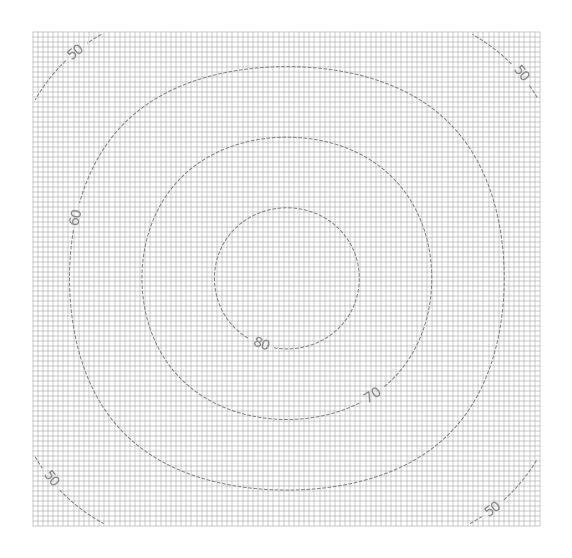

In [3]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_axis_off()

# grid
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    ax.plot(xi, eta, color='grey', linewidth=.4)

xlim, ylim = ax.get_xlim(), ax.get_ylim()

# coastlines 
for cl in grid.projection.get_projected_coastlines(mag=True, apex=apexpy.Apex(refh=0)):
    ax.plot(cl[0], cl[1], color='C0')

# add (magnetic) latitude contours
co = ax.contour(grid.xi, grid.eta, grid.lat, linestyles='--', colors='grey', linewidths=1, levels=np.r_[-80:81:10])
ax.clabel(co, co.levels, inline=True, fontsize=14)

ax.set_xlim(xlim)
ax.set_ylim(ylim);

#### Constant ionospheric conductances

For the purposes of this example, we set the Pedersen $\Sigma_P$ and Hall $\Sigma_H$ conductances to a constant 10 moh across the entire grid (unrealistic values):

In [4]:
SH = np.ones(grid.shape)*10 # [moh]
SP = np.ones(grid.shape)*10 # [moh]

This assumption is the basis of how we can relate an ionospheric electric potential to magnetic field perturbations on ground.

#### Electric potential to FAC densities

In Notebook 01, we calculated the divergence of the ionospheric electric field, $\mathrm{\underline{E}}_{\nabla\cdot}$, from a [Weimer (2005)](https://doi.org/10.1029/2004JA010884) model potential, with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$. The divergence was defined on each of the $N$ cells in the `CSgrid`, $\mathrm{\underline{E}}_{\nabla\cdot}$. We want to use this divergence to represent field-aligned current (FAC) densities, $j_{||}$. We have conductances that are constant across the grid, and therefore no gradients of the Pedersen and Hall conductance. Thus the FAC densities and $\nabla\cdot\mathbf{E}$ can be related through ([Reistad et al. 2019](https://doi.org/10.1029/2019JA026634))

\begin{equation*}
    j_{||} = \Sigma_P\nabla\cdot\mathbf{E}.
\end{equation*}


This is derived from taking the divergence of the (horizontal) ionospheric current density $\nabla\cdot\mathbf{J}_{\perp}$ from the height-integrated Ohm's law, $\mathbf{J}_{\perp}=\Sigma_P\mathbf{E}+\Sigma_H\hat{\mathbf{b}}\times\mathbf{E}$ (with $\nabla\Sigma_P=\nabla\Sigma_H=0$). The use of the ionospheric Ohm's law implies steady-state, and that Faraday's law is zero ($\nabla\times\mathbf{E}=0$).

We load the $\mathrm{\underline{E}}_{\nabla\cdot}$ which we derived from the Weimer potential in Notebook 01 (note that we can do this as the grid in Notebook 01 is identical to the grid we set up earlier in this example):

In [5]:
# load div(E)
df = pd.read_hdf('./datasets/01divE.h5')
divE = (df['divE'].values).reshape(grid.shape)

# calculate FACs
FAC = divE*SH

#### FACs to curl-free SECS amplitudes

The curl-free amplitude of the $i$th SECS basis function, $S^{\star}_i$, represents the total FAC [Ampere]. We relate the FAC density in the $i$th cell, $j_{||,i}$, [Ampere per m$^2$] to $S^{\star}_i$ by multiplying with the area of the $i$th `CSgrid` cell, $A_i$:
\begin{equation}
    S^{\star}_i=j_{||, i}\cdot A_i.
\end{equation}
This is done for all grid cells.

In [6]:
CF_amp = FAC*grid.A

#### Curl-free to divergence-free SECS amplitudes

As there are no conductance gradients along the electric field, and the Hall-to-Pedersen conductance ratio is a constant, the curl-free amplitudes and divergence-free SECS amplitudes, $S^\circ_i$, are related through ([Amm et al., 2002](https://doi.org/10.1029/2002JA009472); [Juusola et al., 2009](https://doi.org/10.1029/2008JA013908)):
\begin{equation}
    S^{\star}_i=-\frac{1}{\alpha_i}S^{\circ}_i,
\end{equation}
where $\alpha_i=\Sigma_H,i/\Sigma_P,i$ is the Hall-to-Pedersen conductance ratio in the $i$th grid cell. Here, $\alpha=1$ for the entire grid, and we can obtain the divergence-free amplitudes through $S^{\circ}_i=-S^{\star}_i$:

In [7]:
DF_amp = -CF_amp

#### Divergence-free SECS amplitudes to magnetic field disturbances 

Observed magnetic disturbances on ground, $\Delta{\mathbf{B}}_g$, are solely due to the divergence-free equivalent currents in the ionosphere, as the magnetic fields of FACs and associated horizontal curl-free currents cancel below the ionosphere in polar regions where the main magnetic field is approximately radial (according to the Fukushima theorem). The divergence-free currents are scaled by $S^{\circ}_i$, and relate to the magnetic field disturbances on ground through:
\begin{equation}
    \Delta\mathrm{\underline{B}}_g=\mathbb{H}^{\circ}_g\mathrm{\underline{S}}^{\circ}
\end{equation}

We use the vectorized implementation of the SECS basis functions to find the matrix $\mathbb{H}^{\circ}_g$ that relates the divergence-free amplitudes to the magnetic field on ground by using `get_SECS_B_G_matrices`. $\mathbb{H}^{\circ}_g$ has elements from Equations (10)-(12) in the Lompe paper ([Laundal et al., 2022](https://doi.org/10.1029/2022JA030356)).

In [8]:
# limit for singularity correction is half a grid cell
secs_singularity_limit = np.min([grid.Wres, grid.Lres])/2

He_mat, Hn_mat, Hu_mat = get_SECS_B_G_matrices(np.ravel(grid.lat_mesh), np.ravel(grid.lon_mesh), Re, 
                                               np.ravel(grid.lat), np.ravel(grid.lon), RI = grid.R,
                                               current_type = 'divergence_free', 
                                               singularity_limit = secs_singularity_limit)

Note that the `current_type` is set to `divergence_free`. The same function can be used to obtain magnetic field distrubances from the curl-free currents, by specifying `curl_free`. For example when evaluating the effect of the ionospheric current above the ionosphere, where both the curl-free and divergence-free part of the ionospheric current contribute to the magnetic disturbances. 

The SECS basis functions are infinite at $\theta_i=0$, which can cause numerical problems. To avoid this, a modification is often applied poleward of some limit $\theta_0$ (as proposed by [Vanhamäki and Juusola, 2020](https://doi.org/10.1007/978-3-030-26732-2_2)), which we here set to half a grid cell.

We set the evaluation points offset from the grid centers (in the corners of the grid cells) to further mitigate the singularity-problem of the SECS basis functions. The radius of evaluation points is set to the Earth radius. The function also needs the locations of $S^\circ_i$, which are located in the center of the grid cells and at the grid altitude.

Note that the function returns three matrices for each of the east, north and up components: $\mathbb{H}^{\circ}_g=\begin{pmatrix}\mathbb{H}^{\circ}_{ge} \\ \mathbb{H}^{\circ}_{gn}\\ \mathbb{H}^{\circ}_{gu} \end{pmatrix}$.

We can now calculate the magntic field disturbances on ground using the above equation. (This is then the magnetic disturbance on ground that would result from the Weimer model potential in an ionosphere with constant Pedersen and Hall conductances of 10 moh.)

In [9]:
Bge, Bgn, Bgu = He_mat.dot(DF_amp.flatten()), Hn_mat.dot(DF_amp.flatten()), Hu_mat.dot(DF_amp.flatten())

#### Plotting

We can visualize the ground magnetic field projected on the `CSgrid` ($\xi, \eta$ coordinates):

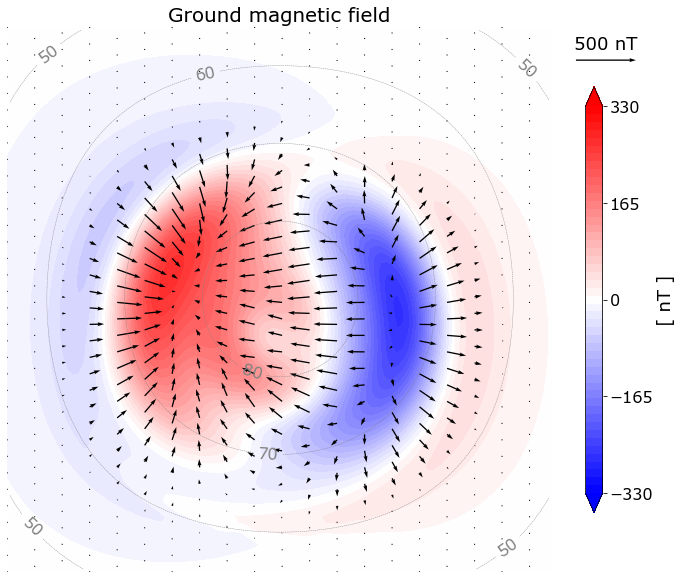

In [10]:
# set up figure
fig = plt.figure(figsize=(10,8.5))
ax  = fig.add_subplot(111)
ax.set_title('Ground magnetic field', fontsize = 20)
ax.set_aspect('equal')
ax.axis('off')

# magnetic latitude contours
c = ax.contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', 
               linewidths = .4, levels = np.r_[-80:81:10])
ax.clabel(c, c.levels, inline = True, fontsize = 16)

# define some scales for color
scale = 600e-9                       # scale for horizontal east, north components [T]
scale_units = 'inches'               # horizontal component unit
cscale = np.linspace(-330, 330, 50)  # colorscale for upward component [nT]
ticks = np.linspace(-330, 330, 5)    # color bar ticks [nT]

# transform horizontal components from (east, north) to cubed sphere (xi,eta) system
x, y, Ax, Ay = grid.projection.vector_cube_projection(Bge.reshape(grid.lon_mesh.shape), 
                                                      Bgn.reshape(grid.lon_mesh.shape), grid.lon_mesh, grid.lat_mesh)

# plot horizontal vectors for some of the evaluation locations
SKIP = 15
q=ax.quiver(x[::SKIP], y[::SKIP], Ax[::SKIP], Ay[::SKIP], scale = scale, scale_units=scale_units, color='black')
ax.quiverkey(q, 1.1, .94, U=500e-9, label='500 nT', fontproperties={'size':18})   # add scale for vectors

# plot upward component and colorbar
Bgu = Bgu.reshape(grid.eta_mesh.shape)
c=ax.contourf(grid.xi_mesh, grid.eta_mesh, Bgu*1e9, cmap=plt.cm.bwr, levels=cscale, zorder=0, extend='both')
cbar=fig.colorbar(c, ax=ax, ticks=ticks, orientation='vertical', shrink=0.7, aspect=25)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel('[ nT ]', fontsize=18)

# adjust
fig.subplots_adjust(left=.05, right=.995, bottom=.001, top=.995)

# save figure
fig.savefig('./output_figures/04SECSexample.pdf')
fig.savefig('./output_figures/04SECSexample.png')

The figure shows the ground magnetic field disturbances resulting from an ionosphere with constant conductances of 10 moh and an ionospheric electric field described by the Weimer model potential. 

The color scale is the vertical component of the magnetic disturbanceon ground (blue is downward, red is upward), and the arrows show the horizontal components of the magnetic disturbance on ground. This is the same way `lompeplot` illustrates ground magnetic field perturbations (e.g., Notebook 07, or notebooks in /lompe_paper_figures/).